# Notebook 1 - Preprocessing + Clustering side project

In [ ]:
################################## MODIFY PATHS TO RUN THE NOTEBOOK #########################################
data_folder = '/content/drive/Othercomputers/My Laptop/סמסטר א/למידה חישובית למדעי המוח/final project/data/'
code_folder = '/content/drive/Othercomputers/My Laptop/סמסטר א/למידה חישובית למדעי המוח/final project/code/'
##############################################################################################################

# mount drive:
from google.colab import drive
drive.mount('/content/drive')

# imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# import custom functions:
import sys
sys.path.append(code_folder)
from ml_final_project_functions import scale_numeric_and_tfidf, grid_search, plot_predictions

Mounted at /content/drive


In [ ]:
# uploads:
# load main dataframe:
df = pd.read_csv(data_folder + 'metadata.tsv',sep='\t')
orig_df = df.copy()  # save for later use

# deal with Nan's:
print('number of Nans in df is', df.isna().sum().sum())
print('Missing values are in the following columns:')
print([col for col in df.isna().sum().index if df.isna().sum()[col] > 0])

# let's remove the 5 NaN values for our dependent variables:
df.dropna(inplace=True, axis=0)
print('number of Nans after dropping is', df.isna().sum().sum())

# load tfidf:
tfidf = pd.read_csv(data_folder + 'features.tsv',sep='\t').drop('Unnamed: 0', axis=1)
orig_tfidf = tfidf.copy()  # save for later use

# deal with Nan's:
print('\nnumber of Nans in tfidf is', tfidf.isna().sum().sum())
# print('Missing values are in the following columns:')
# print([col for col in tfidf.isna().sum().index if tfidf.isna().sum()[col] > 0])   # commented because this line takes ages to run

# let's remove the same 5 NaN values for our dependent variables:
tfidf.dropna(inplace=True, axis=0)
print('number of Nans after dropping is', df.isna().sum().sum())

# check if the indexes of the two dataframes are the same:
print('\ndf index is tfidf index ->', df.index.equals(tfidf.index))

# drop journal & citation count column from tfidf:
tfidf.drop(['journal', 'citation_count'], axis=1, inplace=True)

number of Nans in df is 5
Missing values are in the following columns:
['citation_count']
number of Nans after dropping is 0

number of Nans in tfidf is 5
number of Nans after dropping is 0

df index is tfidf index -> True


---

Notebook 1 table of contents:<br>

Part I - EDA<br>
Part II - Feature engineering<br>
Part III - train-test split + feature selection<br>
Part IV - Clustering side project<br>


---



Part I - Exploratory Data Analysis

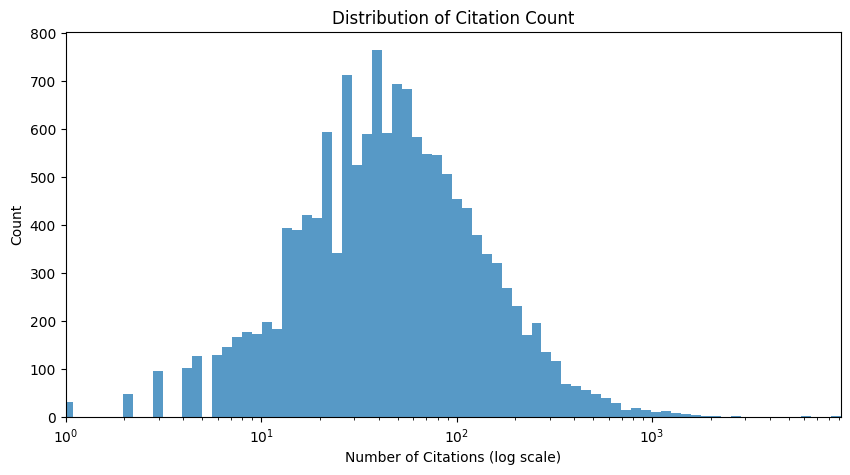

In [ ]:
# 1. Let's observe the distribution of our dependent variable - the number of citations per paper:
ax, fig = plt.subplots(figsize=(10, 5))
plt.xscale('log')
plt.xlim(1, df['citation_count'].max())
plt.xlabel('Number of Citations (log scale)')
sns.histplot(df['citation_count'])
plt.title('Distribution of Citation Count')
plt.show()

<Axes: title={'center': 'Publishing year distribution'}, xlabel='year', ylabel='Count'>

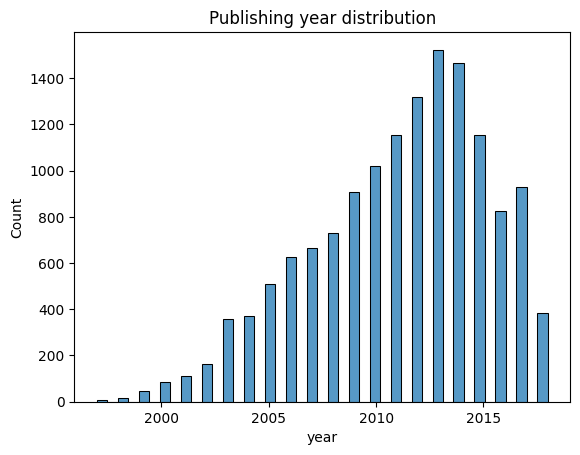

In [ ]:
# 2. publishing year distrubution:
plt.title('Publishing year distribution')
sns.histplot(df['year'])

Text(0.5, 1.0, 'Journal distribution')

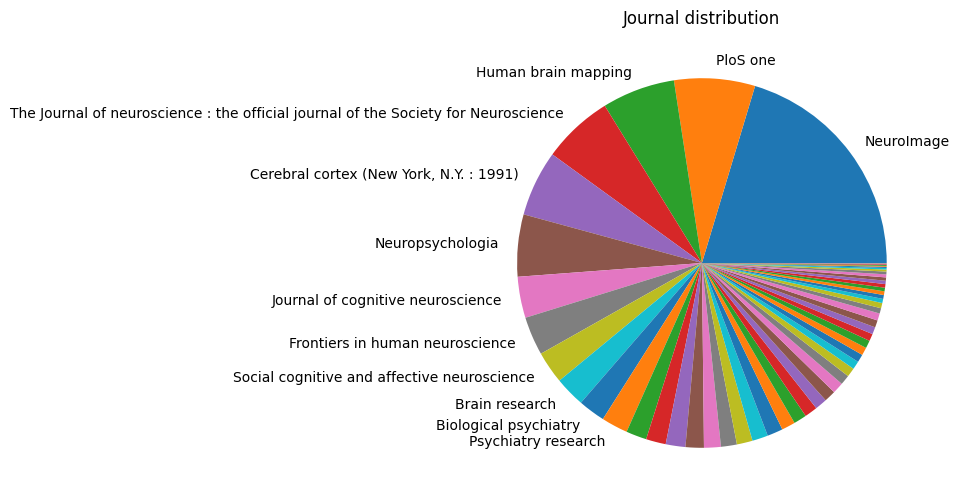

In [ ]:
# 3. pie chart of journals:
plt.figure(figsize=(6, 6))
labels=df['journal'].value_counts().index.to_list()
labels = labels[0:12] + ['' for i in range(len(labels)-12)]
plt.pie(df['journal'].value_counts(), labels = labels)
plt.title('Journal distribution')

Text(0.5, 0, 'mean TF-IDF')

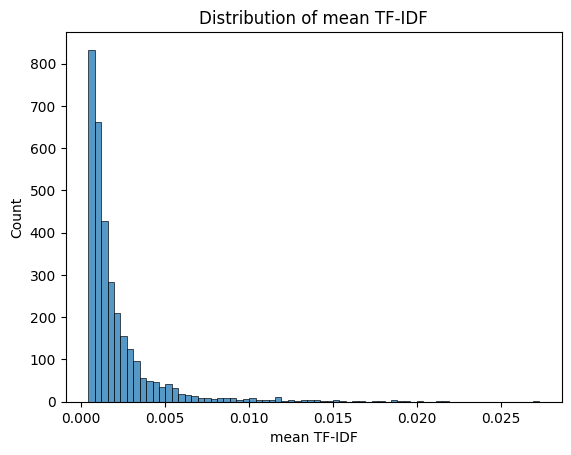

In [ ]:
# 4. observe the mean tf-idf values accross all papers
sns.histplot(tfidf.mean(), bins=70)
plt.title('Distribution of mean TF-IDF')
plt.xlabel('mean TF-IDF')

Part II - Feature engineering

<Axes: title={'center': 'Distribution of number of authors'}, xlabel='number_of_authors', ylabel='Count'>

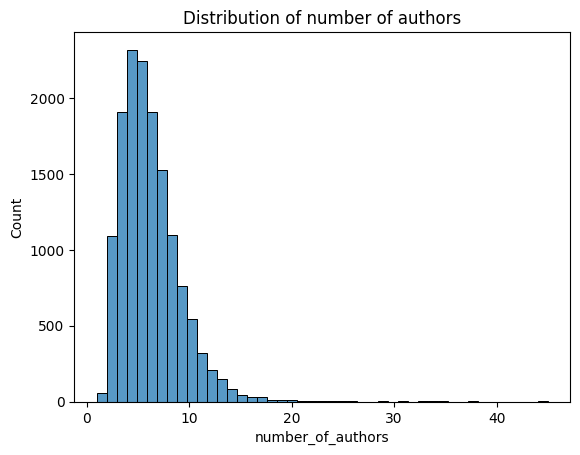

In [ ]:
# number_of_authors column:
# as it's possible that papers with many authors will be cited more.
df['number_of_authors'] = [x.count(',') + 1 for x in df['authors'].to_list()]

# plot:
plt.title('Distribution of number of authors')
sns.histplot(df['number_of_authors'], bins=45)

<Axes: title={'center': 'Distribution of mean number of papers written by the authors'}, xlabel='mean_number_of_papers', ylabel='Count'>

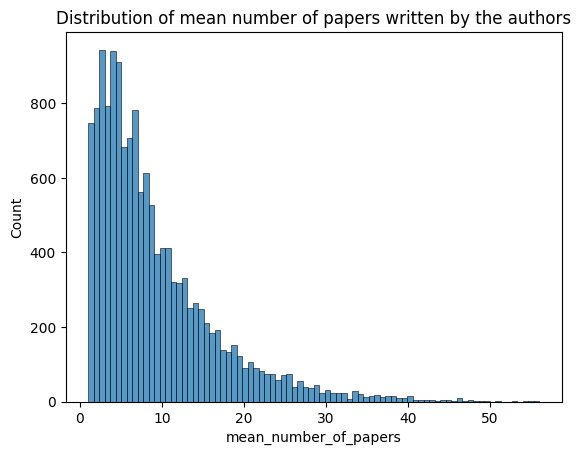

In [ ]:
# mean number of papers:
# for every paper, this feature will represent the mean number of papers in the dataset written by one or more of the authors.
# lt's say a paper is written by X and Y, this feature will be mean of the number of papers written by X & Y.

# helper fucns:
def flatten(xss):
    return [x for xs in xss for x in xs]

def mean_number_of_papers(s):
  "returns the normalized cummulative sum of author feature in a single row"
  sum = 0
  L = s.split(',')
  for x in L:
    sum += d[x]
  return sum / len(L)

# fill a paper count dictionary:
d = {}   # empty dictonary
all_authors = flatten([x.split(',') for x in df['authors'].to_list()])

# fill the dict:
for author in all_authors:
    if author in d:
        d[author] += 1
    else:
        d[author] = 1

# apply coumn:
df['mean_number_of_papers'] = df['authors'].apply(mean_number_of_papers)

# plot:
plt.title('Distribution of mean number of papers written by the authors')
sns.histplot(df['mean_number_of_papers'])

In [ ]:
# create keywords features from the journal name
# binary variables representing if a keyword can be found in the journal name
all_journals = [journal.lower() for journal in df['journal'].to_list()]

# keywords:
# is_psy
df['is_psy'] = [1 if 'psy' in journal else 0 for journal in all_journals]
# is_imaging
df['is_imaging'] = [1 if 'imag' in journal else 0 for journal in all_journals]
# is neuro
df['is_neuro'] = [1 if 'neuro' in journal else 0 for journal in all_journals]
# is_frontiers
df['is_frontiers'] = [1 if 'frontiers' in journal else 0 for journal in all_journals]
# is _brain
df['is_brain'] = [1 if 'brain' in journal else 0 for journal in all_journals]
# is_clinic
df['is_clinic'] = [1 if 'clinical' in journal else 0 for journal in all_journals]
# is_bio
df['is_bio'] = [1 if 'bio' in journal else 0 for journal in all_journals]

Text(0.5, 1.0, 'Distribution of years from publish')

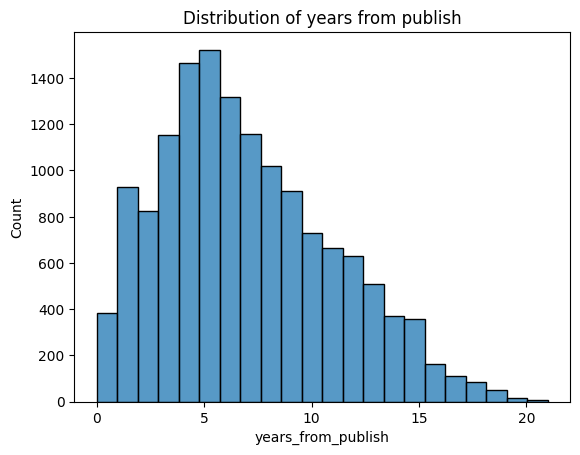

In [ ]:
# convert year to year_from_publish, as it's a more interpetable measure for the number of citations.
# notice - our dataset is up to 2018
df['years_from_publish'] = 2018 - df['year']
# plot:
sns.histplot(df['years_from_publish'], bins=22)
plt.title('Distribution of years from publish')

Text(0.5, 1.0, 'Distribution of number of words in title')

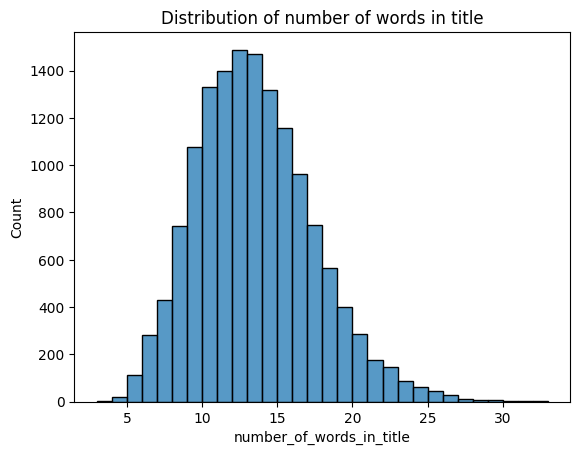

In [ ]:
# number of words in the title
# while it may seem a bit far fetched, it's possible that "catchy" papers with shorter titles will showcase more citations.
df['number_of_words_in_title'] = df['title'].apply(lambda x: len(x.split(' ')))
# plot:
sns.histplot(df['number_of_words_in_title'], bins=30)
plt.title('Distribution of number of words in title')

In [ ]:
# create some keywords from title binary variables:

# first we'll create a dataframe with words frequencies in all the titles, we will choose by hand several keywords:
all_titles = orig_df['title'].to_list()
all_titles = [x.lower().replace('.','').replace(':','') for x in all_titles]
all_titles_broken = [x.split(' ') for x in all_titles]
all_titles_flatten = flatten(all_titles_broken)

d = {} # empty dictionary

for word in all_titles_flatten:
    if word in d:
        d[word] += 1
    else:
        d[word] = 1

# convert to df:
words_df = pd.DataFrame(list(d.items()), columns=['word', 'count'])
words_df.sort_values(by='count', ascending=False, inplace=True)

# save csv:
words_df.to_csv(data_folder + 'words_df.csv')
chosen_keywords = ['functional','connectivity', 'correlates', 'processing', 'activation', 'memory', 'human', 'cortex', 'visual', 'network', 'prefrontal', 'motor', 'patients', 'resting-state', 'auditory', 'attention', 'disorder', 'schizophrenia', 'parkinson\'s', 'alzheimer\'s','magnetic', 'amygdala', 'perception', 'autism']

# assemble the features:
for kw in chosen_keywords:
    df['kw_' + kw] = df['title'].apply(lambda x: 1 if kw in x.lower() else 0)

In [ ]:
# create first author columns for the 50 most frequent first writers:
# for writer X, column fa_X is a binary feature where 1 signifies X is the first author in a paper.
fa_list = df['authors'].apply(lambda x: x.split(',')[0]).value_counts()[0:50].index
for fa in fa_list:
    df['fa_' + fa] = df['authors'].apply(lambda x: 1 if fa in x else 0)

In [ ]:
# create IF variable - the crown jewel!
names = df['journal'].unique()
IF_data = {'journal': names,
           'IF': [
        4.212, 1.690, 9.580, 11.377, 2.619, 8.272, 4.861, 1.364, 2.872, 4.569, 11.501, 	11.814, 2.173, 2.893, 4.554,
        2.784, 3.675, 2.208, 2.089, 2.071, 4.31, 5.562, 2.785, 2.77, 2.700, 5.812, 2.619, 2.651, 1.878, 2.407,
        5.930, 3.424, 3.466, 4.398, 2.627, 2.961, 2.854, 4.468, 3.192, 2.776, 3.436, 3.622, 2.167, 2.080, 4.275, 3.029,
        3.104, 3.418, 2.870, 3.829, 3.757, 2.661, 2.622, 2.184, 4.920, 3.949, 4.17, 4.481, 2.270, 2.800]
    }

IF_df = pd.DataFrame(IF_data)

for index, row in IF_df.iterrows():
    df.loc[df['journal'] == row['journal'], 'IF'] = row['IF']

In [ ]:
# dummy variables:
# create dummy variable to the two categorical features "space" & "journal"
df = pd.get_dummies(df, columns=['space'])
df = pd.get_dummies(df, columns=['journal'])

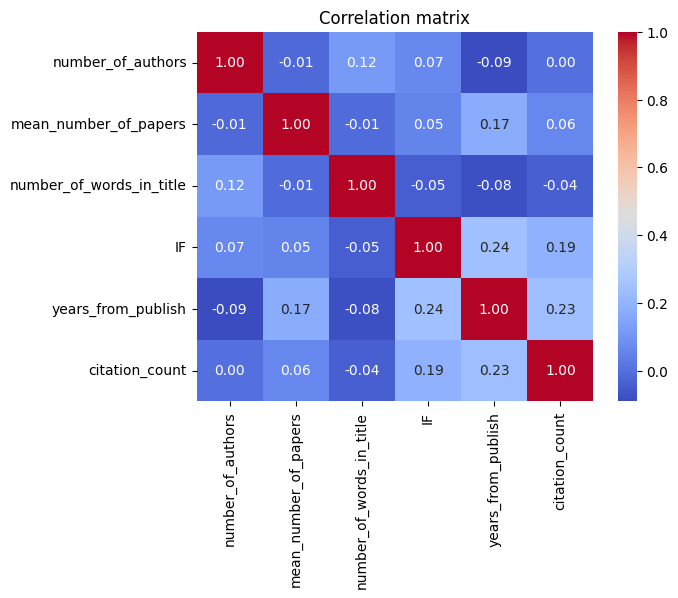

In [ ]:
# check features correlation
selected_columns = ['number_of_authors','mean_number_of_papers','number_of_words_in_title','IF','years_from_publish','citation_count']
corrletion_mat = df[selected_columns].corr()
sns.heatmap(corrletion_mat, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.show()

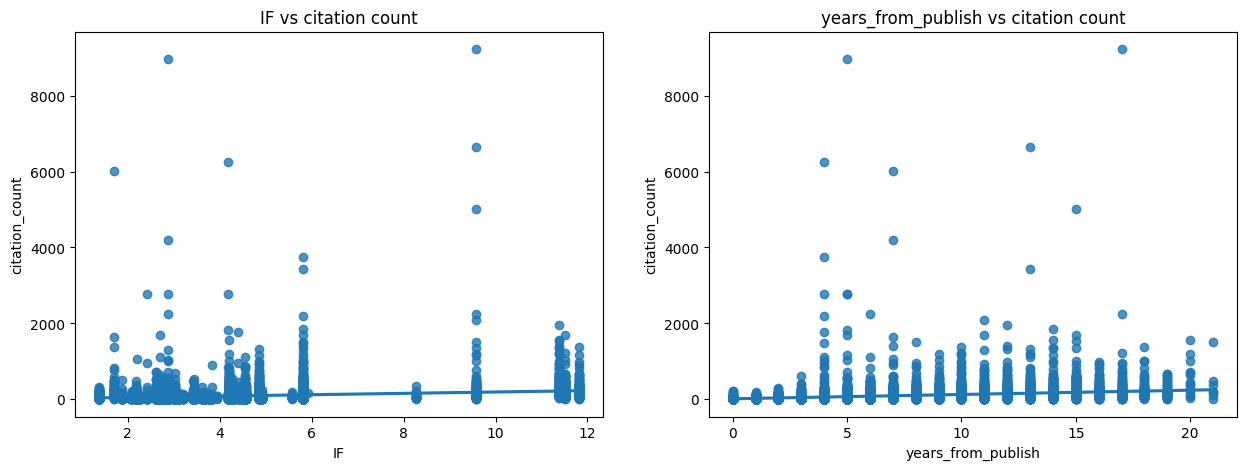

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(data=df, x='IF', y='citation_count', ax=ax1)
sns.regplot(data=df, x='years_from_publish', y='citation_count', ax=ax2)
ax1.set_title('IF vs citation count')
ax2.set_title('years_from_publish vs citation count')
plt.show()

# note - both measures seem to prdict for most features,
# but do not predict for the outliers with alot of citations!

In [ ]:
# add polynomial features to the non tfidf numerical features:
degree = 4 # sounds right
features_for_poly = ['number_of_authors','mean_number_of_papers','number_of_words_in_title','IF','years_from_publish']
poly = PolynomialFeatures(degree=degree)
poly.fit(df[features_for_poly])
poly_df = pd.DataFrame(poly.transform(df[features_for_poly]), columns=poly.get_feature_names_out(features_for_poly), index=df.index)
print('poly df shape is', poly_df.shape)
df.drop(features_for_poly, axis=1, inplace=True)
df = pd.concat([df, poly_df], axis=1)
print('df shape is', df.shape)

poly df shape is (14366, 126)
df shape is (14366, 276)


Part III - train test split

Note - we initally intended on conducting cross-validation, but since the huge anount of data, we did not have the computational power and/or enough patience and decided to use only a single validation set :)

In [ ]:
# remove unnecessary columns:
df.drop(['id', 'doi', 'authors', 'title', 'year'], axis=1, inplace=True)

# make tfidf column markers
tfidf.columns = ['tfidf_' + col for col in tfidf.columns]

# save list of numeric columns:
numeric_cols = poly_df.columns.to_list()
tfidf_cols = tfidf.columns.to_list()

# add tfidf data:
df = pd.concat([df, tfidf], axis=1)

# split to X & y:
y = df['citation_count']
X = df.drop(['citation_count'], axis=1)

# split to train-val-test:.

test_val_size = int(len(df) * 0.15)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_val_size, random_state=1008, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_val_size, random_state=1008, shuffle=True)

# scale tha data:
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_and_tfidf(X_train, X_val, numeric_cols, tfidf_cols, X_test)

# sanity check:
print('X train shape is', X_train.shape)
print('X val shape is', X_val.shape)
print('X test shape is', X_test.shape)
print('y train shape is', y_train.shape)
print('y val shape is', y_val.shape)
print('y test shape is', y_test.shape)

# pack the files for the new notebook:

# data v1:
data_v1 = {'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'numeric_cols': numeric_cols,
        'tfidf_cols': tfidf_cols}

pd.to_pickle(data_v1, data_folder + 'processed_data_v1.pkl')
print('all pickeled')

X train shape is (10058, 3498)
X val shape is (2154, 3498)
X test shape is (2154, 3498)
y train shape is (10058,)
y val shape is (2154,)
y test shape is (2154,)
all pickeled


In [ ]:
# data v2 - use f_regression to pick x percent of the features:
x = 0.25      # sounds right, might be modified
k = int(df.shape[1] * x)
print('using', k, 'features')

# scale all the data:
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_and_tfidf(X_train, X_val, numeric_cols, tfidf_cols, X_test)

# pick k-best:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.datasets import make_regression
selector = SelectKBest(score_func=f_regression, k=k).fit(X_train_scaled, y_train)   # fit only on the train set

# Get indices of selected features
selected_indices = selector.get_support(indices=True)

# Get names of selected features
selected_feature_names = [X_train.columns[i] for i in selected_indices]

# Transform training, validation, and test sets
X_train_kbest = X_train_scaled[selected_feature_names]
X_val_kbest = X_val_scaled[selected_feature_names]
X_test_kbest = X_test_scaled[selected_feature_names]

# sanity check:
print('X_train_kbest shape is', X_train_kbest.shape)
print('X_val_kbest shape is', X_val_kbest.shape)
print('X_test_kbest shape is', X_test_kbest.shape)

# fix numeric_cols and tfidf_cols
tfidf_cols_v2 = [col for col in tfidf_cols if col in selected_feature_names]
numeric_cols_v2 = [col for col in numeric_cols if col in selected_feature_names]

# pack:
data_v2 = {'X_train': X_train_kbest,
        'X_val': X_val_kbest,
        'X_test': X_test_kbest,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'numeric_cols': numeric_cols_v2,
        'tfidf_cols': tfidf_cols_v2}

# pickle:
pd.to_pickle(data_v2, data_folder + 'processed_data_v2.pkl')
print('all pickeled')

using 874 features
X_train_kbest shape is (10058, 874)
X_val_kbest shape is (2154, 874)
X_test_kbest shape is (2154, 874)
all pickeled


In [ ]:
# data v3 - PCA
from sklearn.decomposition import PCA
explained_variance = 0.95  # can be modified

# scale all the data:
X_train_scaled, X_val_scaled, X_test_scaled = scale_numeric_and_tfidf(X_train, X_val, numeric_cols, tfidf_cols, X_test)

# PCA:
pca = PCA(n_components=explained_variance)

# fit:
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

num_components = pca.n_components_
print('num_components is', num_components)

# turn to dfs:
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'pca_{i}' for i in range(X_train_pca.shape[1])], index=X_train_scaled.index)
X_val_pca = pd.DataFrame(X_val_pca, columns=[f'pca_{i}' for i in range(X_val_pca.shape[1])], index = X_val_scaled.index)
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'pca_{i}' for i in range(X_test_pca.shape[1])], index = X_test_scaled.index)

# sanity check:
print('X_train_pca shape is', X_train_pca.shape)
print('X_val_pca shape is', X_val_pca.shape)
print('X_test_pca shape is', X_test_pca.shape)

# pack:
data_v3 = {'X_train': X_train_pca,
        'X_val': X_val_pca,
        'X_test': X_test_pca,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'pca': pca}

# pickle:
pd.to_pickle(data_v3, data_folder + 'processed_data_v3.pkl')
print('all pickeled')

num_components is 19
X_train_pca shape is (10058, 19)
X_val_pca shape is (2154, 19)
X_test_pca shape is (2154, 19)
all pickeled


In [ ]:
# data v4 - kbest + pca

# concat:
X_train_v4 = pd.concat([X_train_kbest, X_train_pca], axis=1)
X_val_v4 = pd.concat([X_val_kbest, X_val_pca], axis=1)
X_test_v4 = pd.concat([X_test_kbest, X_test_pca], axis=1)

# sanity check:
print('X_train_v4 shape is', X_train_v4.shape)
print('X_val_v4 shape is', X_val_v4.shape)
print('X_test_v4 shape is', X_test_v4.shape)

# save together:
data_v4 = {'X_train': X_train_v4,
        'X_val': X_val_v4,
        'X_test': X_test_v4,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test}

# pickle:
pd.to_pickle(data_v4, data_folder + 'processed_data_v4.pkl')
print('all pickeled')

X_train_v4 shape is (10058, 893)
X_val_v4 shape is (2154, 893)
X_test_v4 shape is (2154, 893)
all pickeled


In [ ]:
# data v5 - all_data + pca

# concat:
X_train_v5 = pd.concat([X_train_scaled, X_train_pca], axis=1)
X_val_v5 = pd.concat([X_val_scaled, X_val_pca], axis=1)
X_test_v5 = pd.concat([X_test_scaled, X_test_pca], axis=1)

# sanity check:
print('X_train_v5 shape is', X_train_v5.shape)
print('X_val_v5 shape is', X_val_v5.shape)
print('X_test_v5 shape is', X_test_v5.shape)

# save together:
data_v5 = {'X_train': X_train_v5,
        'X_val': X_val_v5,
        'X_test': X_test_v5,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test}

# pickle:
pd.to_pickle(data_v5, data_folder + 'processed_data_v5.pkl')
print('all pickeled')

X_train_v5 shape is (10058, 3517)
X_val_v5 shape is (2154, 3517)
X_test_v5 shape is (2154, 3517)
all pickeled


Part IV - clustering side project



---


in this side project we will:<br>
A. use hirerchical clustering to pick the optimal number of clusters.<br>
B. assign the k-means algorithm on the optimal k.<br>
C. use Anova to find out if those clusters differ in their mean citations count.<br>
D. A positive answer will strenghen our belief in which our features can predict the number of citations.<br>


---



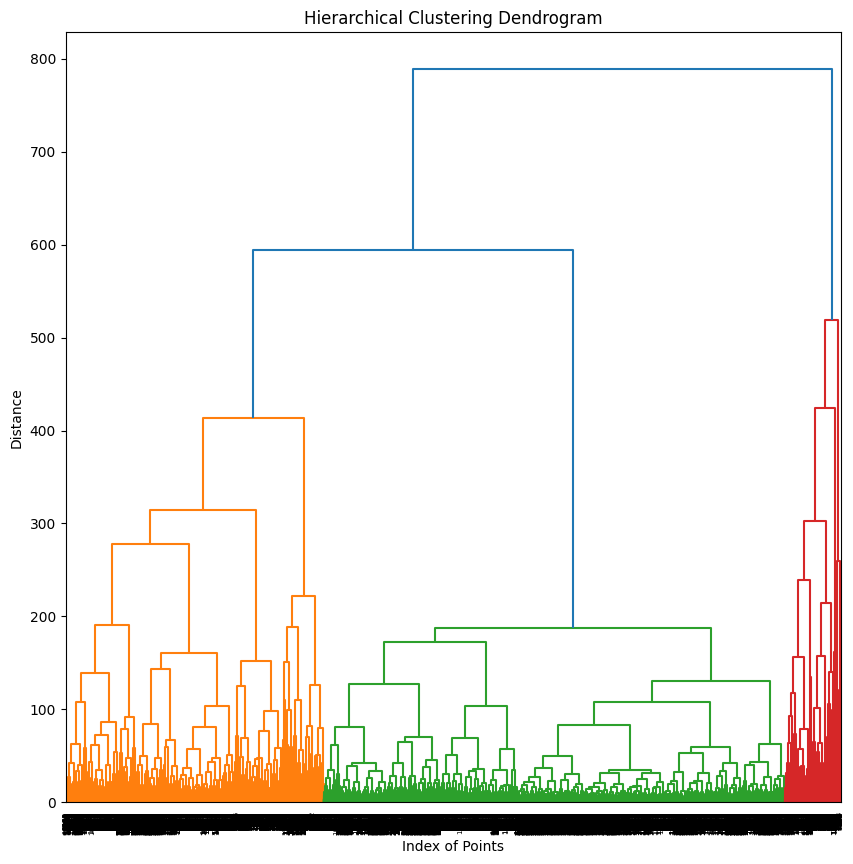

In [ ]:
# A. Hirerchical clustering - ! Notice this cell takes a long time to run !
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# scale the data as we are using euclidian distances:
X_scaled, _ = scale_numeric_and_tfidf(X, X_val, numeric_cols, tfidf_cols, None)

# linkage:
linked = linkage(X_scaled, 'ward')
# plot:
plt.figure(figsize=(10, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index of Points')
plt.ylabel('Distance')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster 0 has 2073 papers
cluster 1 has 11557 papers
cluster 2 has 736 papers


                  sum_sq       df           F         PR(>F)
C(Cluster)  2.629084e+07      2.0  331.048095  2.773065e-141
Residual    5.703329e+08  14363.0         NaN            NaN


Text(0.5, 1.0, 'Mean citations per cluster')

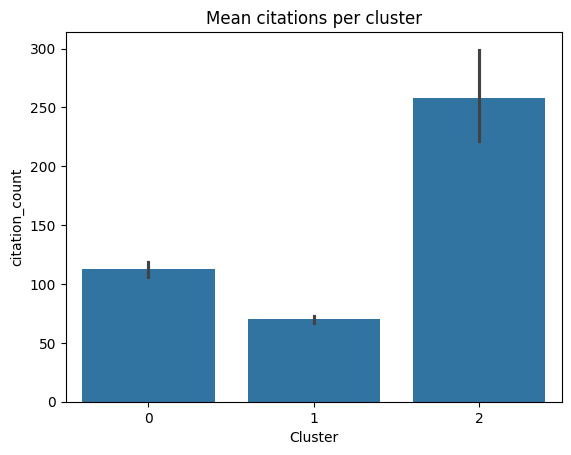

In [ ]:
# B. it seems that k = 3  is a reasonable choice.
# in addition, we know that only a few papers have a very large citation count,
# let's check wether the number of citations differ between the two main clusters:

from sklearn.cluster import KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)

# print the number of papers per cluster:
for cluster in range(k):
    print('cluster', cluster, 'has', X[X['Cluster'] == cluster].shape[0], 'papers')

print('\n') # space a bit

# C. ANOVA test - does the number of citations differs between clusters?
import statsmodels.api as sm
from statsmodels.formula.api import ols

# organize table
anova_df = pd.DataFrame({'Cluster': X['Cluster'],
                         'citation_count': y,
                         'IF': X['IF'],
                         'years_from_publish': X['years_from_publish'],
                         'mean_number_of_papers': X['mean_number_of_papers'],
                         'IF years_from_publish interaction': X['IF years_from_publish']})

# run test:
anova_df.rename(columns={'citation_count': 'citation_count'}, inplace=True)
model = ols('citation_count ~ C(Cluster)', data=anova_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

# plot the results:
sns.barplot(data=anova_df, x='Cluster', y='citation_count')
plt.title('Mean citations per cluster')

Text(0.5, 1.0, 'Mean IF years_from_publish interaction per cluster')

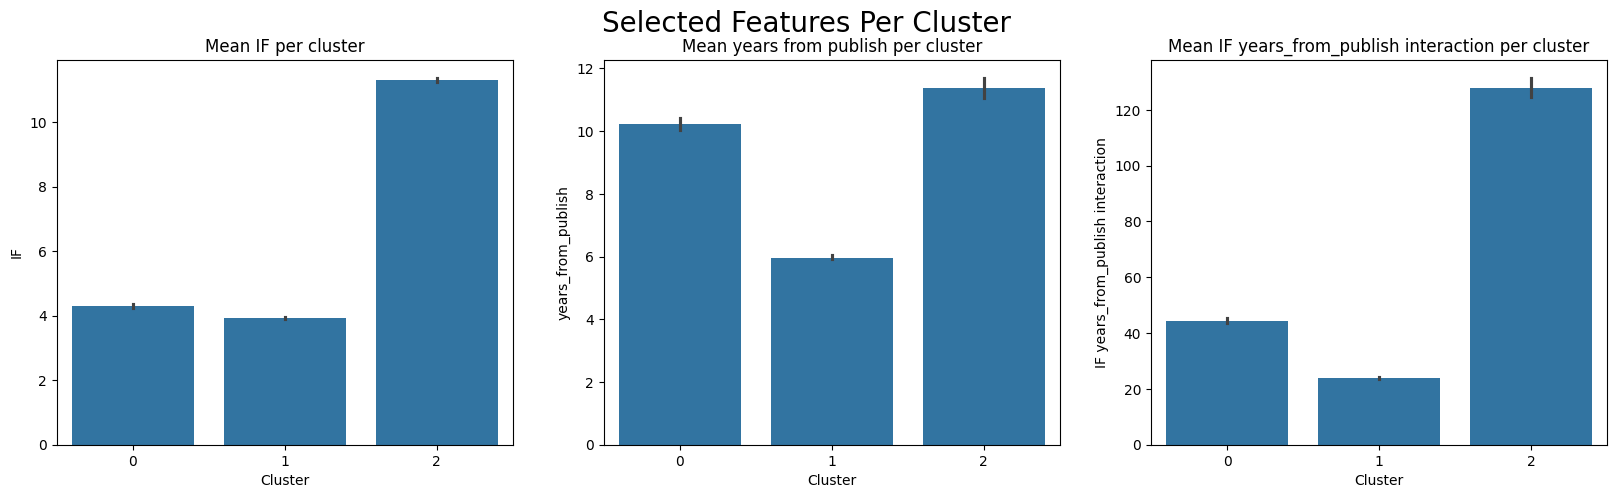

In [ ]:
# It seems like the clusters are defined by the number of citations a paper recieves, let's delve deeper and figure out if other
# interpertable features differ between the clusters:

# plot a 1 x 3 grid:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()
plt.suptitle('Selected Features Per Cluster', size=20)

sns.barplot(data=anova_df, x='Cluster', y='IF', ax=axs[0])
axs[0].set_title('Mean IF per cluster')

sns.barplot(data=anova_df, x='Cluster', y='years_from_publish', ax=axs[1])
axs[1].set_title('Mean years from publish per cluster')

sns.barplot(data=anova_df, x='Cluster', y='IF years_from_publish interaction', ax=axs[2])
axs[2].set_title('Mean IF years_from_publish interaction per cluster')

Text(0.5, 1.0, 'IF vs years_from_publish by cluster')

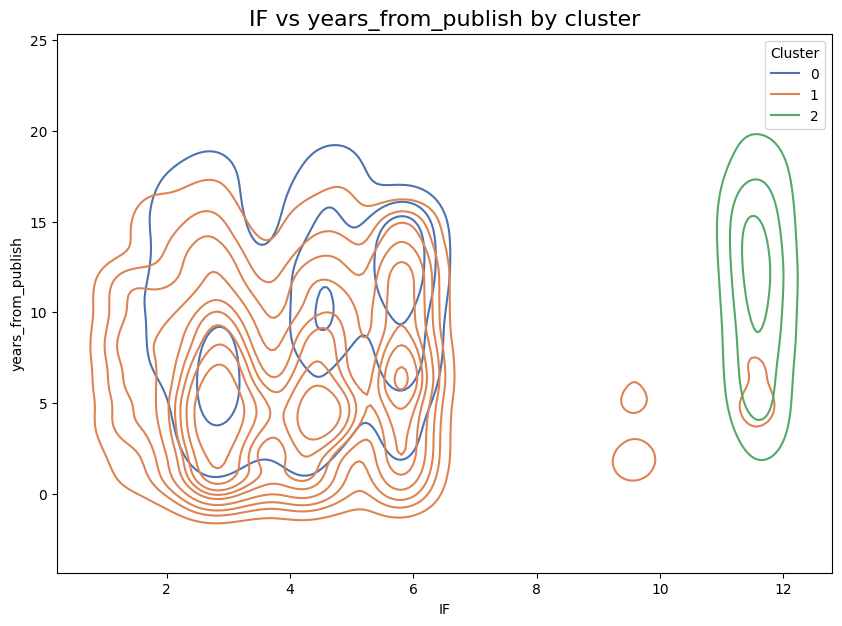

In [ ]:
# plot IF vs years_from_publish by cluster:
plt.figure(figsize=(10, 7))
sns.kdeplot(data=anova_df, x='IF', y='years_from_publish', hue='Cluster', palette='deep', fill=False)
plt.title('IF vs years_from_publish by cluster', size=16)

Text(0.5, 1.0, 'IF years_from_publish interaction by cluster')

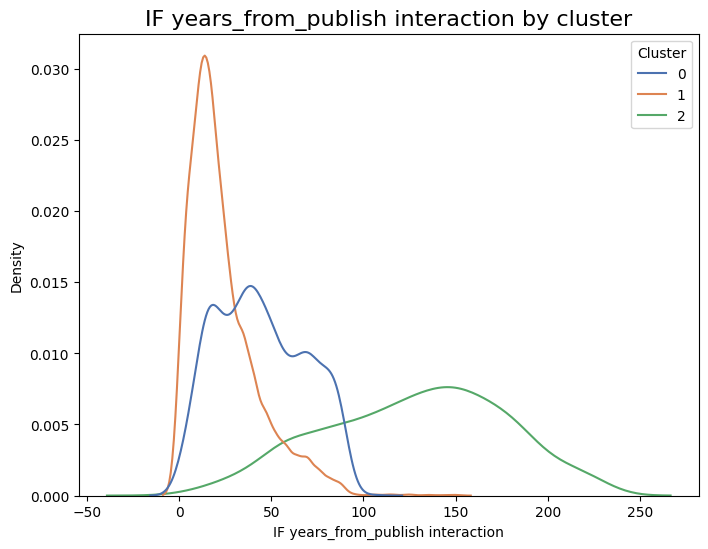

In [ ]:
# plot the distribution of the interaction:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=anova_df, x='IF years_from_publish interaction', hue='Cluster', palette='deep', common_norm=False)
plt.title('IF years_from_publish interaction by cluster', size=16)